In [10]:
#CRISP-DM Project Outline
#This notebook provides an outline for a data science project following the CRISP-DM methodology.
#State of art
#Aujourd’hui, les plateformes de mobilité comme Uber utilisent beaucoup les nouvelles technologies et l’analyse des informations pour mieux fonctionner et offrir une meilleure expérience aux utilisateurs. Elles arrivent ainsi à relever plusieurs défis, comme donner un prix plus juste en temps réel, prévoir plus précisément l’heure d’arrivée d’un véhicule, ou encore mieux connaître les habitudes des clients afin de leur proposer des offres adaptées. En s’appuyant sur l’étude de grandes quantités de données issues des trajets, du comportement des passagers et des conditions extérieures comme le trafic, la météo ou l’heure de la journée, ces entreprises réussissent à prendre de meilleures décisions. Cela leur permet d’être plus efficaces, de réduire les annulations de courses et de renforcer la fidélité des clients.#1. Business Understanding
#Define the Business Objectives (BOs)
#BO 1:Fournir une estimation fiable et rapide du coût d’un trajet Uber.
#BO 2:Réduire les temps d’attente des passagers d'un uberen prédisant leur ETA (Estimated Time of Arrival)
#BO 3:Identifier et anticiper les zones de forte demande (hotspots) afin de mieux répartir les chauffeurs et éviter les ruptures de disponibilité.
#Define the Data Science Objectives (DSOs)
#DSO 1:Construire un modèle de régression robuste qui prédit le fare_amount avec une erreur faible (MAE/RMSE bas/R2 élevé).
#DSO 2:Développer un modèle prédictif capable d’estimer la durée du trajet afin de fournir au client un temps d’arrivée réaliste
#DSO 3:Appliquer des techniques de clustering non supervisé (ex. K-Means, DBSCAN) pour segmenter les trajets selon le lieu


📌 Dimensions du dataset : (44377, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194.000000,2015-05-07 19:52:06.0000003,7.500000,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1.000000
1,27835199.000000,2009-07-17 20:04:56.0000002,7.700000,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1.000000
2,44984355.000000,2009-08-24 21:45:00.00000061,12.900000,nan,-74.005043,40.740770,nan,40.772647,1.000000
3,25894730.000000,2009-06-26 08:22:21.0000001,5.300000,2009-06-26 08:22:21 UTC,-73.976124,nan,-73.965316,40.803349,3.000000
4,17610152.000000,2014-08-28 17:47:00.000000188,16.000000,2014-08-28 17:47:00 UTC,nan,40.744085,-73.973082,nan,5.000000
5,44470845.000000,2011-02-12 02:27:09.0000006,4.900000,2011-02-12 02:27:09 UTC,-73.969019,40.755910,-73.969019,40.755910,1.000000
6,48725865.000000,2014-10-12 07:04:00.0000002,24.500000,2014-10-12 07:04:00 UTC,nan,40.693965,-73.871195,40.774297,5.000000
7,44195482.000000,2012-12-11 13:52:00.00000029,2.500000,2012-12-11 13:52:00 UTC,0.000000,0.000000,0.000000,0.000000,1.000000
8,15822268.000000,2012-02-17 09:32:00.00000043,9.700000,2012-02-17 09:32:00 UTC,-73.975187,40.745767,-74.002720,40.743537,1.000000
9,50611056.000000,2012-03-29 19:06:00.000000273,12.500000,2012-03-29 19:06:00 UTC,-74.001065,40.741787,-73.963040,nan,1.000000



📈 Statistiques descriptives :


,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,42243.000000,42217.000000,42183.000000,42130.000000,42183.000000,42119.000000,42159.000000
mean,27672899.814928,11.409233,-72.568666,39.948790,-72.588555,39.957229,1.677720
std,16026783.122156,10.091979,10.776933,6.006307,10.684628,5.962407,1.296484
min,48.000000,0.000000,-748.016667,-74.015515,-737.916665,-74.008745,0.000000
25%,13724835.500000,6.000000,-73.992075,40.734808,-73.991496,40.733766,1.000000
50%,27651919.000000,8.500000,-73.981857,40.752503,-73.980170,40.752910,1.000000
75%,41510200.500000,12.600000,-73.967187,40.767077,-73.963738,40.768162,2.000000
max,55421687.000000,350.000000,40.774042,45.031653,40.828377,45.031598,6.000000



Infos générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44377 entries, 0 to 44376
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         42243 non-null  float64
 1   key                42143 non-null  object 
 2   fare_amount        42217 non-null  float64
 3   pickup_datetime    42094 non-null  object 
 4   pickup_longitude   42183 non-null  float64
 5   pickup_latitude    42130 non-null  float64
 6   dropoff_longitude  42183 non-null  float64
 7   dropoff_latitude   42119 non-null  float64
 8   passenger_count    42159 non-null  float64
dtypes: float64(7), object(2)
memory usage: 3.0+ MB
None

Valeurs manquantes par colonne :
Unnamed: 0           2134
key                  2234
fare_amount          2160
pickup_datetime      2283
pickup_longitude     2194
pickup_latitude      2247
dropoff_longitude    2194
dropoff_latitude     2258
passenger_count      2218
dtype: int64

Nombre

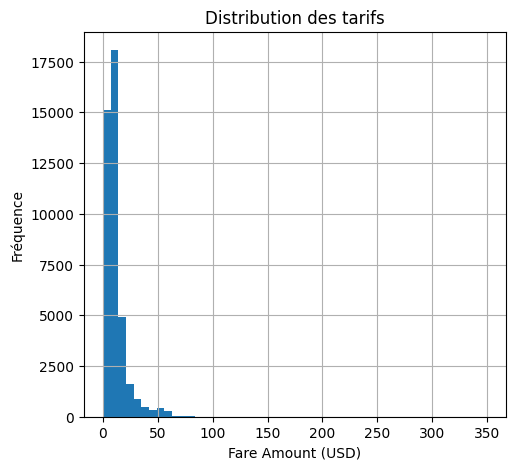

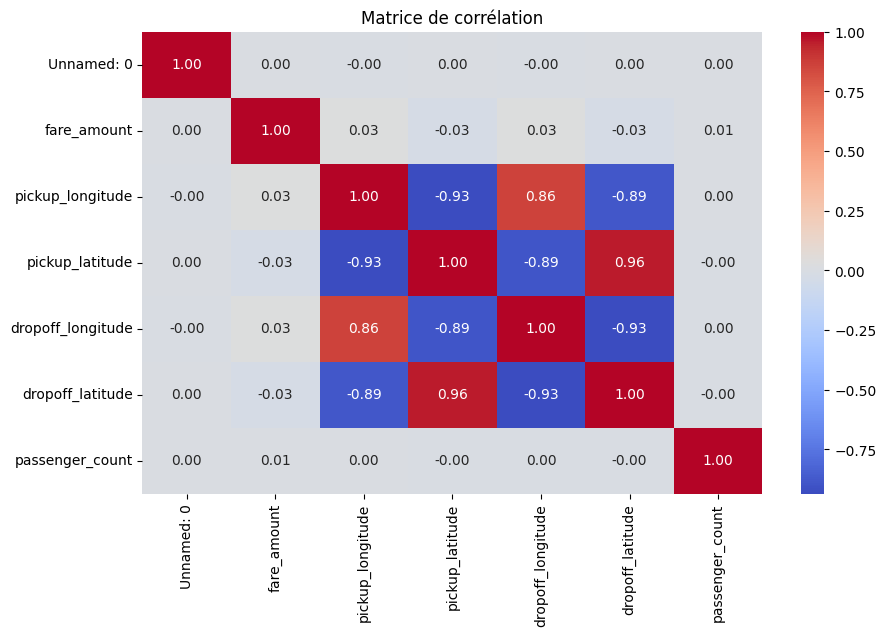

In [11]:
#2. Data Understanding
#Collect and get an initial understanding of the data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Charger le dataset Excel (adapter le chemin)
df = pd.read_excel("datauber.xlsx")   # Mets le vrai nom de ton fichier

print("📌 Dimensions du dataset :", df.shape)
display(df.head(10).style.set_caption("Aperçu des 10 premières lignes")
        .background_gradient(cmap="Blues"))

# ========== 3. Statistiques descriptives ==========
print("\n📈 Statistiques descriptives :")
display(df.describe().style.background_gradient(cmap="Oranges"))


print("\nInfos générales :")
print(df.info())

# 3. Vérifier valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())



# 6. Visualisations simples
plt.figure(figsize=(12,5))

# Distribution des tarifs
plt.subplot(1,2,1)
df["fare_amount"].hist(bins=50)
plt.xlabel("Fare Amount (USD)")
plt.ylabel("Fréquence")
plt.title("Distribution des tarifs")


# 7. Vérifier cohérence pickup vs dropoff (distance = 0)
same_location = df[
    (df["pickup_longitude"] == df["dropoff_longitude"]) &
    (df["pickup_latitude"] == df["dropoff_latitude"])
]
print(f"\nNombre de trajets avec même départ et arrivée : {len(same_location)}")

# ========== Réglages d'affichage ==========
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)
pd.set_option("display.width", 1000)

# 2.5 Matrice de corrélation
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()


In [51]:
#Data preparation DSO1
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Haversine function (unchanged)
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    r = 6371  # Earth's radius in km
    return c * r

# Assuming 'df' is already loaded with the specified columns
# Apply Haversine function
df['distance_km'] = df.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'],
                                                  row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

# Feature engineering (unchanged)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, errors='coerce')
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['is_night'] = df['hour'].apply(lambda x: 1 if x >= 22 or x < 6 else 0)
df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if x in [7, 8, 9, 16, 17, 18] else 0)
df['distance_hour_interaction'] = df['distance_km'] * df['hour']

# Clean data
df = df[df['distance_km'] > 0]  # Remove zero distances
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]  # Remove fare outliers
df = df[(df['distance_km'] > 0) & (df['distance_km'] < 50)]  # Remove distance outliers

# Features
features = [
    "distance_km", "hour", "day_of_week", "passenger_count",
    "distance_hour_interaction", "is_weekend", "is_night", "is_peak_hour", "month"
]
X = df[features]
y = df["fare_amount"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [31]:
#Data preparation for DSO2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import radians, cos, sin, asin, sqrt
from datetime import timedelta
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Charger le dataset
df = pd.read_excel("datauber.xlsx")

# === Nettoyage et préparation (repris de ton code) ===
df = df.drop_duplicates()
df["fare_amount"] = df["fare_amount"].fillna(df["fare_amount"].median())
for col in ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]:
    df[col] = df[col].fillna(df[col].median())

df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")
most_freq_date = df["pickup_datetime"].mode()[0]
df["pickup_datetime"] = df["pickup_datetime"].fillna(most_freq_date)

df = df[(df["fare_amount"] > 0) & (df["fare_amount"] < 200)]
df = df[(df["passenger_count"] > 0) & (df["passenger_count"] <= 6)]
df = df[(df["pickup_longitude"] > -80) & (df["pickup_longitude"] < -70)]
df = df[(df["pickup_latitude"] > 35) & (df["pickup_latitude"] < 45)]
df = df[(df["dropoff_longitude"] > -80) & (df["dropoff_longitude"] < -70)]
df = df[(df["dropoff_latitude"] > 35) & (df["dropoff_latitude"] < 45)]
df = df[~((df["pickup_longitude"] == df["dropoff_longitude"]) &
          (df["pickup_latitude"] == df["dropoff_latitude"]))]

# pickup_time = pickup_datetime
df["pickup_time"] = df["pickup_datetime"]

# Traffic_level basé sur l'heure de booking_time (calculé après génération)
def traffic_from_hour(hour, day_of_week):
    if 0 <= hour < 5: return 0
    elif 5 <= hour < 7: return 1
    elif 7 <= hour < 9 or 17 <= hour < 19: return 4
    elif 9 <= hour < 10 or 16 <= hour < 17: return 3
    elif 10 <= hour < 16: return 2
    else: return 1 if day_of_week < 5 else 3

# Génération synthétique de booking_time (réservation avant pickup)
df["temp_traffic_level"] = df.apply(lambda row: traffic_from_hour(row["pickup_time"].hour, row["pickup_time"].dayofweek), axis=1)
df["waiting_minutes"] = np.random.uniform(5, 30, len(df)) + df["temp_traffic_level"] * 3  # Délai ajusté par trafic
df["booking_time"] = df["pickup_time"] - df.apply(lambda row: timedelta(minutes=row["waiting_minutes"]), axis=1)

# Recalculer traffic_level basé sur booking_time
df["booking_hour"] = df["booking_time"].dt.hour
df["booking_dayofweek"] = df["booking_time"].dt.dayofweek
df["traffic_level"] = df.apply(lambda row: traffic_from_hour(row["booking_hour"], row["booking_dayofweek"]), axis=1)

# Cible : waiting_time_min
df["waiting_time_min"] = (df["pickup_time"] - df["booking_time"]).dt.total_seconds() / 60.0
df = df[(df["waiting_time_min"] > 0) & (df["waiting_time_min"] < 120)]

# Features : hour, minute, dayofweek pour booking_time et pickup_time, plus traffic_level
df["booking_minute"] = df["booking_time"].dt.minute
df["pickup_hour"] = df["pickup_time"].dt.hour
df["pickup_minute"] = df["pickup_time"].dt.minute
df["pickup_dayofweek"] = df["pickup_time"].dt.dayofweek

features = ["booking_hour", "booking_minute", "booking_dayofweek",
            "pickup_hour", "pickup_minute", "pickup_dayofweek",
            "traffic_level"]
X = df[features]
y = df["waiting_time_min"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [60]:
#Data preparation DSO3
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
np.random.seed(42)

# Charger le dataset
df = pd.read_excel("datauber.xlsx")

# === Nettoyage et préparation des données ===
df = df.drop_duplicates()

df["fare_amount"] = df["fare_amount"].fillna(df["fare_amount"].median())
for col in ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]:
    df[col] = df[col].fillna(df[col].median())

df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")
most_freq_date = df["pickup_datetime"].mode()[0]
df["pickup_datetime"] = df["pickup_datetime"].fillna(most_freq_date)

# Nettoyage valeurs aberrantes
df = df[(df["fare_amount"] > 0) & (df["fare_amount"] < 200)]

# Coordonnées réalistes NYC
df = df[(df["pickup_longitude"] > -80) & (df["pickup_longitude"] < -70)]
df = df[(df["pickup_latitude"] > 35) & (df["pickup_latitude"] < 45)]
df = df[(df["dropoff_longitude"] > -80) & (df["dropoff_longitude"] < -70)]
df = df[(df["dropoff_latitude"] > 35) & (df["dropoff_latitude"] < 45)]

# pickup != dropoff
df = df[~((df["pickup_longitude"] == df["dropoff_longitude"]) &
          (df["pickup_latitude"] == df["dropoff_latitude"]))]

# Sélection des features pour clustering : coordonnées géographiques
geo_features = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
X_geo = df[geo_features]

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_geo)

# Appliquer PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Variance expliquée par PCA : {pca.explained_variance_ratio_.sum():.2f}")

Variance expliquée par PCA : 0.68


In [38]:

#Modeling DSO1
#XGBOOST
# Optimisation des hyperparamètres avec GridSearchCV pour XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleur modèle
model = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)

# Prédictions
y_pred = model.predict(X_test)



Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [50]:
# Modeling Random Forest model DSO1
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [53]:
#Modeling Linear Regression DSO1
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)



In [33]:
#Modeling DSO2
# Modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [29]:
# Modèle Linear Regression DSO2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# On suppose que X_train, X_test, y_train, y_test, features, et df sont déjà définis
# (après la préparation des données comme dans ton code)


model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



In [21]:
#Modeling DSO3
import folium  # Nouvelle dépendance pour carte HTML

# === Grid Search pour K-Means ===
n_clusters_range = range(2, 11)  # Tester de 2 à 10 clusters
silhouette_scores = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Silhouette Score pour K-Means avec {n_clusters} clusters : {silhouette_avg:.2f}")

# Trouver le nombre optimal de clusters
optimal_n_clusters = n_clusters_range[np.argmax(silhouette_scores)]
print(f"\nNombre optimal de clusters (basé sur le score de silhouette) : {optimal_n_clusters}")

# Appliquer K-Means avec le nombre optimal de clusters
kmeans_optimal = KMeans(n_clusters=optimal_n_clusters, random_state=42)
df["kmeans_cluster"] = kmeans_optimal.fit_predict(X_pca)



# === Clustering avec DBSCAN ===
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajuste eps et min_samples selon tes données
df["dbscan_cluster"] = dbscan.fit_predict(X_pca)



R² Score: 0.75
Mean Absolute Error (MAE): 2.59
Root Mean Squared Error (RMSE): 4.60

Exemple de valeurs réelles et prédites :
 fare_amount_réel  fare_amount_prédit  distance_km
              6.5                5.06         0.48
              4.9                5.82         0.96
             16.1               18.00         6.33
             11.5               11.33         3.45
             14.5               17.95         6.86
              7.3                8.57         2.22
              8.0                8.05         1.64
              8.0                6.49         1.00
             11.0                7.53         1.74
              8.5                7.48         1.48


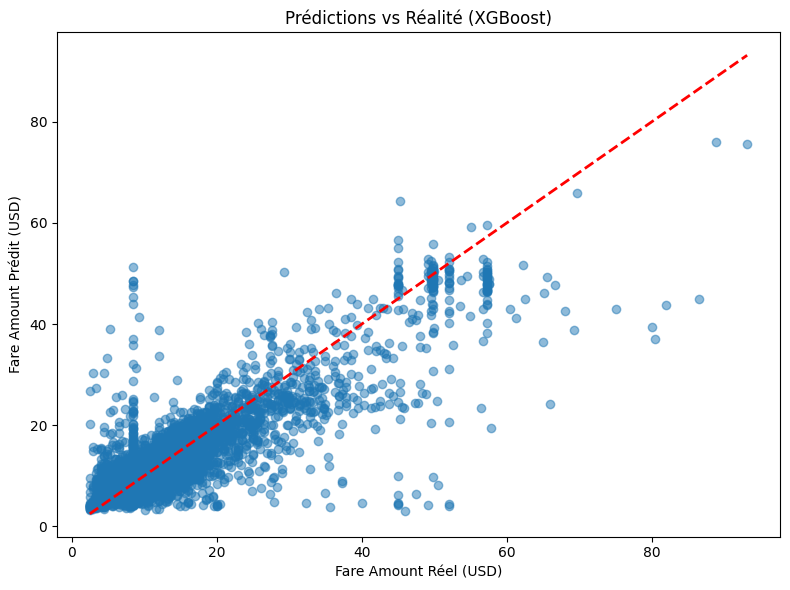

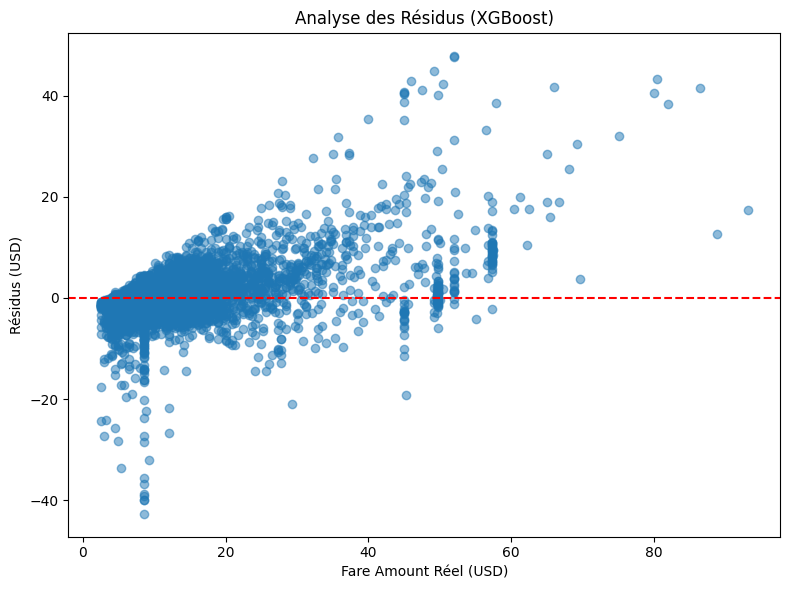

In [58]:
# Évaluation dso 1
#XGBOOST
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Exemple de valeurs réelles et prédites
results = pd.DataFrame({
    "fare_amount_réel": y_test,
    "fare_amount_prédit": y_pred,
    "distance_km": df.loc[y_test.index, "distance_km"]
})
print("\nExemple de valeurs réelles et prédites :")
print(results.head(10).round(2).to_string(index=False))

# Visualisation des prédictions vs réalité
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Fare Amount Réel (USD)")
plt.ylabel("Fare Amount Prédit (USD)")
plt.title("Prédictions vs Réalité (XGBoost)")
plt.tight_layout()
plt.show()

# Analyse des résidus
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fare Amount Réel (USD)")
plt.ylabel("Résidus (USD)")
plt.title("Analyse des Résidus (XGBoost)")
plt.tight_layout()
plt.show()



R² Score: 0.76
Mean Absolute Error (MAE): 2.57
Root Mean Squared Error (RMSE): 4.53

Exemple de 10 valeurs réelles et prédites :
 fare_amount_réel  fare_amount_prédit  distance_km
              6.5                5.48        -0.81
              4.9                6.07        -0.68
             16.1               19.00         0.85
             11.5               10.91         0.03
             14.5               17.74         1.00
              7.3                8.60        -0.32
              8.0                7.59        -0.48
              8.0                6.03        -0.66
             11.0                7.64        -0.45
              8.5                7.91        -0.53


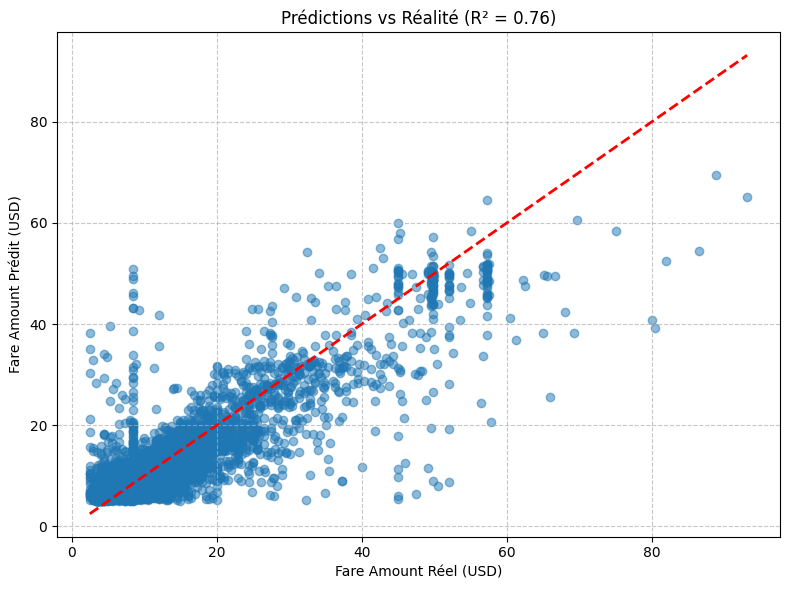

In [49]:
# Evaluation Random Forest DSO1
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Create results DataFrame
# Since X_test is a NumPy array, use the index of "distance_km" (0) from features
results = pd.DataFrame({
    "fare_amount_réel": y_test,
    "fare_amount_prédit": y_pred,
    "distance_km": X_test[:, 0]  # Access the first column (distance_km)
})
print("\nExemple de 10 valeurs réelles et prédites :")
print(results.head(10).round(2).to_string(index=False))

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Fare Amount Réel (USD)")
plt.ylabel("Fare Amount Prédit (USD)")
plt.title(f"Prédictions vs Réalité (R² = {r2:.2f})")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Mean Absolute Error (MAE): 2.59
Root Mean Squared Error (RMSE): 4.60
R² Score: 0.75

Exemple de 10 valeurs réelles et prédites :
 fare_amount_réel  fare_amount_prédit  distance_km
              6.5                5.06        -0.81
              4.9                5.82        -0.68
             16.1               18.00         0.85
             11.5               11.33         0.03
             14.5               17.95         1.00
              7.3                8.57        -0.32
              8.0                8.05        -0.48
              8.0                6.49        -0.66
             11.0                7.53        -0.45
              8.5                7.48        -0.53


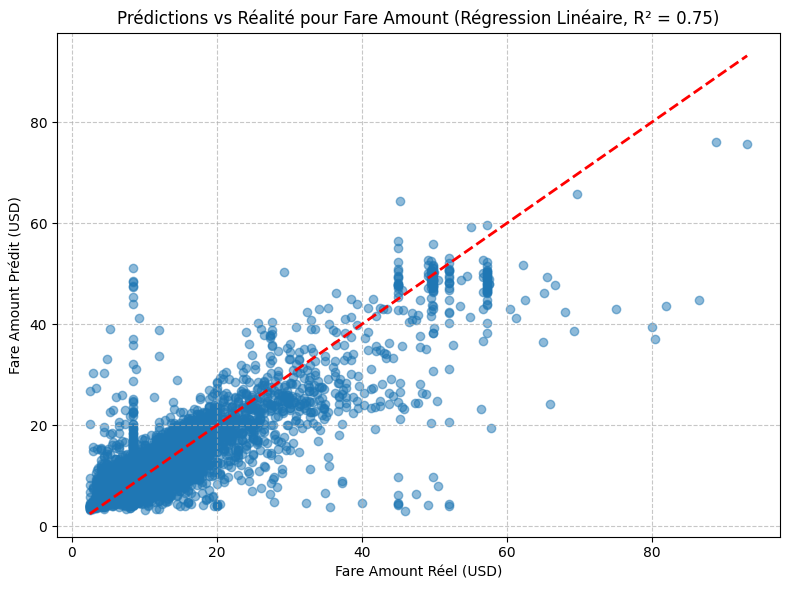

In [54]:
#Evaluation Linear regression DSO1
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Create results DataFrame
# Use X_test[:, 0] for distance_km (first column in features)
results = pd.DataFrame({
    "fare_amount_réel": y_test,
    "fare_amount_prédit": y_pred,
    "distance_km": X_test[:, 0]  # Access scaled distance_km
})
print("\nExemple de 10 valeurs réelles et prédites :")
print(results.head(10).round(2).to_string(index=False))

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Fare Amount Réel (USD)")
plt.ylabel("Fare Amount Prédit (USD)")
plt.title(f"Prédictions vs Réalité pour Fare Amount (Régression Linéaire, R² = {r2:.2f})")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Mean Absolute Error (MAE): 0.48 minutes
Root Mean Squared Error (RMSE): 0.62 minutes
R² Score: 0.99

Exemple de 10 valeurs réelles et prédites :
 waiting_time_real_min  waiting_time_pred_min                     booking_time               pickup_time  booking_hour  booking_minute  booking_dayofweek  pickup_hour  pickup_minute  pickup_dayofweek  traffic_level
                 29.34                  28.77 2010-04-23 17:55:13.312484+00:00 2010-04-23 18:24:34+00:00            17              55                  4           18             24                 4              4
                 37.09                  36.80 2010-10-21 07:34:51.864646+00:00 2010-10-21 08:11:57+00:00             7              34                  3            8             11                 3              4
                 39.36                  38.02 2015-06-08 06:24:30.262683+00:00 2015-06-08 07:03:52+00:00             6              24                  0            7              3                 0           

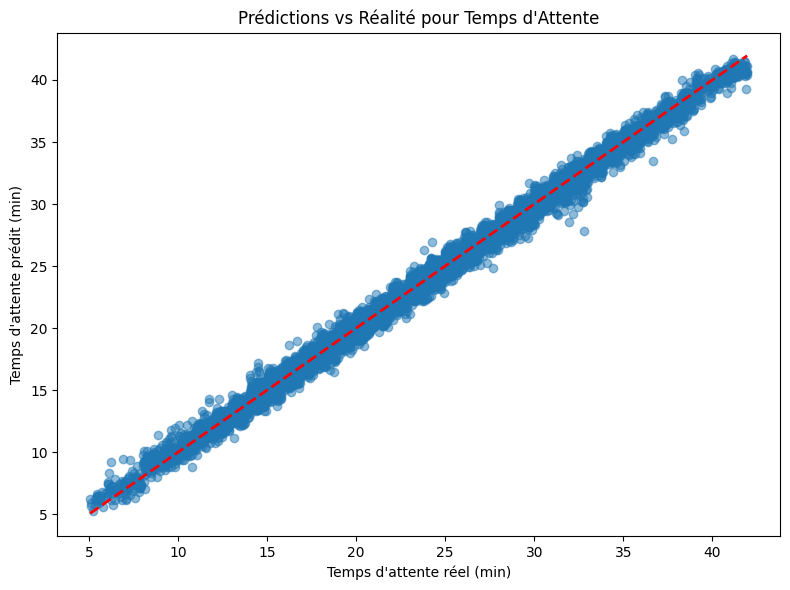


Dataset sauvegardé dans 'waiting_time_data_components.csv' pour vérification.


In [34]:
# Évaluation  DSO2
#Random Forest
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")
print(f"R² Score: {r2:.2f}")

# Exemple de 10 valeurs réelles et prédites
results = pd.DataFrame({
    "waiting_time_real_min": y_test,
    "waiting_time_pred_min": y_pred,
    "booking_time": df.loc[y_test.index, "booking_time"],
    "pickup_time": df.loc[y_test.index, "pickup_time"],
    **{f: X_test[f] for f in features}
})
print("\nExemple de 10 valeurs réelles et prédites :")
print(results.head(10).round(2).to_string(index=False))

# Importance des features
feature_importance = pd.DataFrame({
    "feature": features,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)
print("\nImportance des features :")
print(feature_importance.to_string(index=False))

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Temps d'attente réel (min)")
plt.ylabel("Temps d'attente prédit (min)")
plt.title("Prédictions vs Réalité pour Temps d'Attente")
plt.tight_layout()
plt.show()

# Sauvegarde
df[["booking_time", "pickup_time", "waiting_time_min"] + features].to_csv("waiting_time_data_components.csv", index=False)
print("\nDataset sauvegardé dans 'waiting_time_data_components.csv' pour vérification.")

Mean Absolute Error (MAE): 6.32 minutes
Root Mean Squared Error (RMSE): 7.38 minutes
R² Score: 0.15

Exemple de 10 valeurs réelles et prédites :
 waiting_time_real_min  waiting_time_pred_min                     booking_time               pickup_time  booking_hour  booking_minute  booking_dayofweek  pickup_hour  pickup_minute  pickup_dayofweek  traffic_level
                 29.34                  28.51 2010-04-23 17:55:13.312484+00:00 2010-04-23 18:24:34+00:00            17              55                  4           18             24                 4              4
                 37.09                  28.90 2010-10-21 07:34:51.864646+00:00 2010-10-21 08:11:57+00:00             7              34                  3            8             11                 3              4
                 39.36                  21.07 2015-06-08 06:24:30.262683+00:00 2015-06-08 07:03:52+00:00             6              24                  0            7              3                 0           

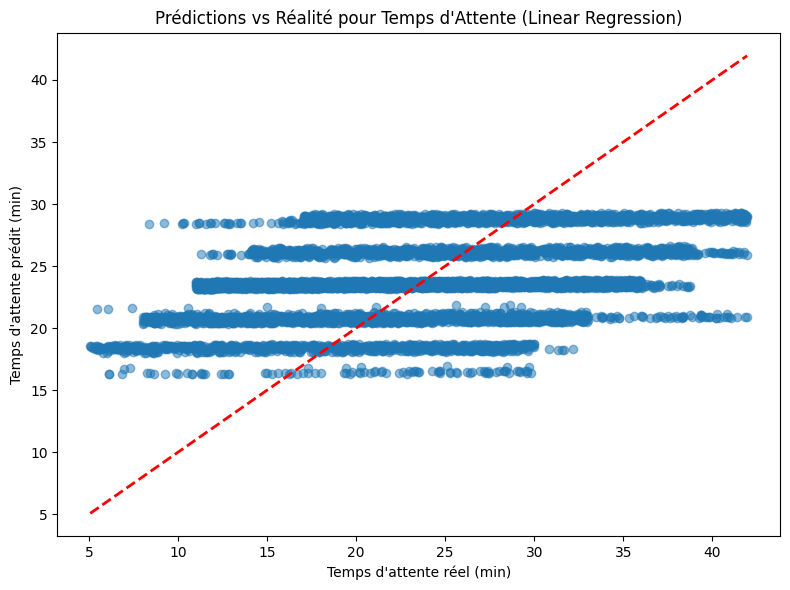

In [30]:
# Évaluation Linear Regression DSO2
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")
print(f"R² Score: {r2:.2f}")

# Exemple de 10 valeurs réelles et prédites
results = pd.DataFrame({
    "waiting_time_real_min": y_test,
    "waiting_time_pred_min": y_pred,
    "booking_time": df.loc[y_test.index, "booking_time"],
    "pickup_time": df.loc[y_test.index, "pickup_time"],
    **{f: X_test[f] for f in features}
})
print("\nExemple de 10 valeurs réelles et prédites :")
print(results.head(10).round(2).to_string(index=False))

# Pas d'importance des features pour Linear Regression (utilise les coefficients si besoin)
print("\nCoefficients des features pour Linear Regression :")
coeffs = pd.DataFrame({
    "feature": features,
    "coefficient": model.coef_
}).sort_values("coefficient", ascending=False)
print(coeffs.to_string(index=False))

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Temps d'attente réel (min)")
plt.ylabel("Temps d'attente prédit (min)")
plt.title("Prédictions vs Réalité pour Temps d'Attente (Linear Regression)")
plt.tight_layout()
plt.show()

In [ ]:
#evaluation DSO3
# Évaluation K-Means avec le nombre optimal
silhouette_kmeans = silhouette_score(X_pca, df["kmeans_cluster"])
print(f"Silhouette Score pour K-Means avec {optimal_n_clusters} clusters : {silhouette_kmeans:.2f}")
# Évaluation DBSCAN (seulement si au moins 2 clusters, ignore les bruits pour le score)
if len(np.unique(df["dbscan_cluster"])) > 1:
    silhouette_dbscan = silhouette_score(X_pca[df["dbscan_cluster"] != -1], df["dbscan_cluster"][df["dbscan_cluster"] != -1])
    print(f"Silhouette Score pour DBSCAN : {silhouette_dbscan:.2f}")
else:
    print("DBSCAN n'a pas produit assez de clusters pour évaluation.")

# Visualisation des clusters K-Means
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["kmeans_cluster"], palette="viridis")
plt.title(f"Clusters K-Means (après PCA, {optimal_n_clusters} clusters)")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")

# Visualisation des clusters DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["dbscan_cluster"], palette="viridis")
plt.title("Clusters DBSCAN (après PCA)")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")

plt.tight_layout()
plt.show()

# === Exportation d'une carte HTML pour les zones fréquentes avec DBSCAN ===
# Centrer la carte sur la moyenne des coordonnées de pickup (NYC approx.)
map_center = [df["pickup_latitude"].mean(), df["pickup_longitude"].mean()]
m = folium.Map(location=map_center, zoom_start=11)

# Ajouter des marqueurs pour chaque point avec couleur selon le cluster DBSCAN
for index, row in df.iterrows():
    if row["dbscan_cluster"] != -1:  # Ignorer les points bruit
        color = f'#{np.random.randint(0, 0xFFFFFF):06x}'  # Couleur aléatoire par point (pour simplicité)
        folium.CircleMarker(
            location=[row["pickup_latitude"], row["pickup_longitude"]],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6
        ).add_to(m)

# Sauvegarder la carte en fichier HTML
m.save("dbscan_map.html")


In [ ]:
#6. DEPLOYMENT
#Implement the chosen model into a real-world application or deliver the results to stakeholders.